In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.join(Path().absolute(), os.pardir)))

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from frequency_response import FrequencyResponse
from biquad import peaking, low_shelf, high_shelf, digital_coeffs
from constants import ROOT_DIR

In [42]:
fns = {'PK': peaking, 'LS': low_shelf, 'HS': high_shelf}
fs = 48000
f = [20.0]
while f[-1] < fs:
    f.append(f[-1]*2**(1/32))
f = np.array(f)

def peq2fr(fc, q, gain, filts):
    c = np.zeros(f.shape)
    for i, filt in enumerate(filts):
        a0, a1, a2, b0, b1, b2 = fns[filt](fc[i], q[i], gain[i], fs=fs)
        c += digital_coeffs(f, fs, a0, a1, a2, b0, b1, b2)
    fr = FrequencyResponse(name='PEG', frequency=f, raw=c)
    return fr

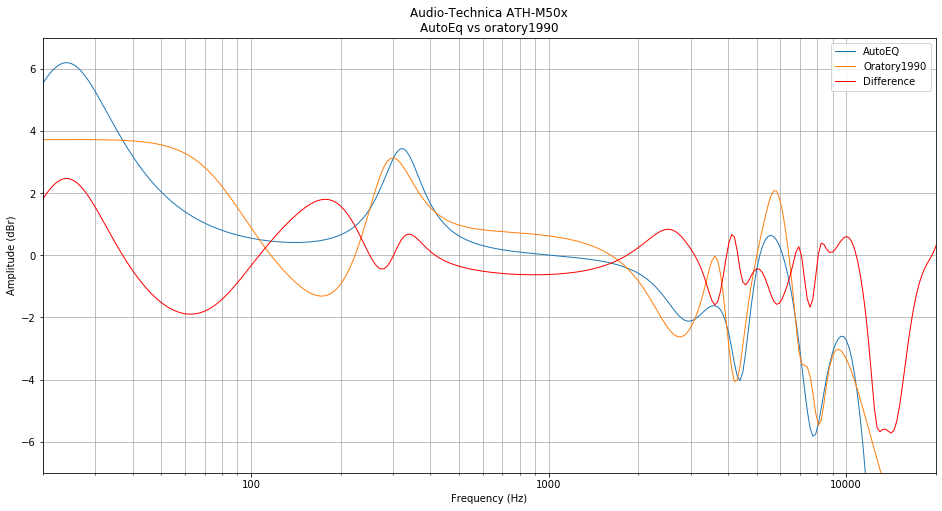

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

autoeq = peq2fr(
    [24, 322, 2947, 14388, 19893, 4419, 5501, 7712, 10169, 12622],
    [0.91, 2.34, 1.94, 1.35, 0.38, 4.45, 1.37, 3.23, 1.9, 4.29],
    [6.2, 3.4, -2.2, -9.1, -8.0, -5.0, 3.5, -5.7, 2.8, -3.2],
    ['PK'] * 10
)

oratory1990 = peq2fr(
    [90, 200, 290, 2800, 3670, 4240, 5800, 7000, 8100, 11000],
    [0.9, 0.9, 1.8, 1.5, 4.5, 4.5, 3.5, 6.0, 5.0, 0.8],
    [2.8, -3.3, 4.5, -3.7, 2.7, -5.0, 2.8, -3.0, -4.6, -10.0],
    ['LS'] + ['PK'] * 8 + ['HS'],
)

diff = FrequencyResponse(name='diff', frequency=f, raw=autoeq.raw - oratory1990.raw)
delta = np.mean(diff.raw[np.logical_and(f >= 100, f <= 10000)])
oratory1990.raw += delta
diff.raw = autoeq.raw - oratory1990.raw

autoeq.plot_graph(fig=fig, ax=ax, show=False, color='C0')
oratory1990.plot_graph(fig=fig, ax=ax, show=False, color='C1')
diff.plot_graph(fig=fig, ax=ax, show=False, color='red')

ax.legend(['AutoEQ', 'Oratory1990', 'Difference'])
ax.set_ylim([-7, 7])
ax.set_title('Audio-Technica ATH-M50x\nAutoEq vs oratory1990')
plt.savefig('Audio-Technica ATH-M50x.png')
plt.show()
